# scANVI label prediction 

This notebook uses scANVI (https://www.embopress.org/doi/full/10.15252/msb.20209620) to co-embed the Xenium HDM day 3 and day 30 data with the Hurskainen et al. scRNA-seq reference and predict cell type labels in the Xenium data. The reference is prepared in [00_scRNAseq_reference.ipynb](00_scRNAseq_reference.ipynb)

In [1]:
import sys
import os
import math
import shutil
import zipfile

In [2]:
import anndata as ad
import squidpy as sq

import pandas as pd
import scanpy as sc
import scvi
import numpy as np

from lightning.pytorch import seed_everything

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

seed_everything(12345)
scvi.settings.seed = 12345

/home/workspace/environment/cellcharter-env2/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/workspace/environment/cellcharter-env2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 12345
Seed set to 12345


In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*default value of 'ignore' for the `na_action` parameter.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*No data for colormapping provided via 'c'.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*ImplicitModificationWarning.*")
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 20  

## Local file info

In [12]:
# data input folder - update to where Xenium input data is saved and unzipped
data_input_folder = '/home/workspace/data/temp/mouse_lung'
if not os.path.exists (data_input_folder):
    os.makedirs(data_input_folder)

# folder to save outputs
out_dir = '/home/workspace/spatial_mouse_lung_outputs/cell_labeling/ouputs_mouselung_hurskainen_ref_consolidate_labels_xenseg_HDM'
if not os.path.exists (out_dir):
    os.makedirs(out_dir)

### File info

In [ ]:
# for adata
dir_list = [
    '/home/workspace/data/temp/mouse_lung/output-XETG00195__0037002__TIS08779-002-003__20241016__230427',
    '/home/workspace/data/temp/mouse_lung/output-XETG00195__0036990__TIS08778-00-003__20241016__230427',
]

sample_list = ['TIS08779', 
               'TIS08778',
              ]

### Import adata for each sample

In [19]:
def h5_to_adata(dir, sample_ID):
    """
    Load a spatial transcriptomics dataset from an h5 and corresponding cell metadata file into an AnnData object.

    Parameters
    ----------
    dir : str
        Path to the directory containing:
        - 'cell_feature_matrix.h5': the gene expression matrix in 10x HDF5 format.
        - 'cells.csv.gz': a gzipped CSV file with cell-level metadata, including spatial coordinates.
    
    sample_ID : str
        A string identifying the sample, added to the `.obs` dataframe of the AnnData object.

    Returns
    -------
    adata : anndata.AnnData
        The annotated single-cell data object with spatial coordinates and sample ID included.
    """
    
    # file names    
    h5_file = os.path.join(dir, 'cell_feature_matrix.h5')
    cells_file = os.path.join(dir, 'cells.csv.gz')
    
    # h5 to adata
    adata = sc.read_10x_h5(
        filename=h5_file
    )
    
    # cells file
    df = pd.read_csv(
        cells_file, 
        compression = 'gzip'
    )
    
    # set indx
    df.set_index(adata.obs_names, inplace=True)
    adata.obs = df.copy()
    
    # x, y
    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

    # add sample
    adata.obs['sample'] = sample_ID
    
    return adata

In [20]:
adata_list = []
for i, path in enumerate(dir_list):
    print('dir: ', path)
    sample_id = sample_list[i]
    print('sample id: ', sample_id)
    adata = h5_to_adata(path, sample_id)
    adata_list.append(adata)

dir:  /home/workspace/data/temp/mouse_lung/output-XETG00195__0037002__TIS08779-002-003__20241016__230427
sample id:  TIS08779
dir:  /home/workspace/data/temp/mouse_lung/output-XETG00195__0036990__TIS08778-00-003__20241016__230427
sample id:  TIS08778


### QC metrics

0 TIS08779


/home/workspace/environment/cellcharter-env2/lib/python3.12/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


1 TIS08778


/home/workspace/environment/cellcharter-env2/lib/python3.12/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


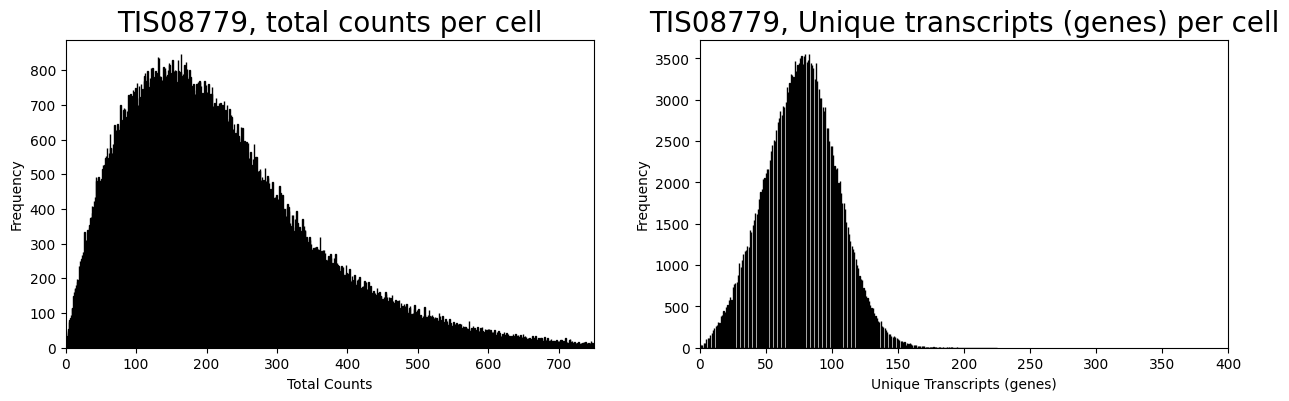

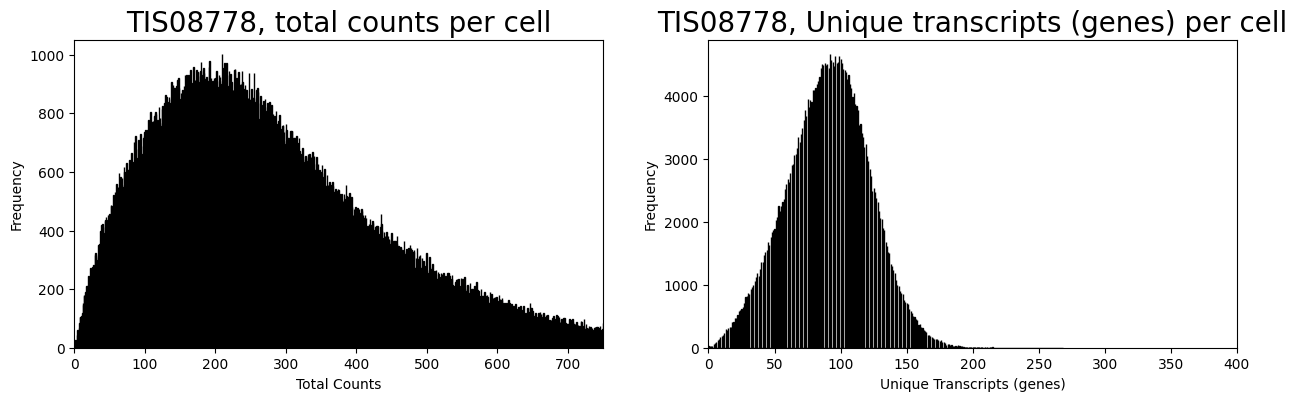

In [21]:
adata_list_qc = []
for i, adata_sample in enumerate(adata_list):
    sample_id = adata_sample.obs['sample'].iloc[0]
    print(i, sample_id)
    
     # filter out control probes and codewords
    filtered_genes = ~adata_sample.var_names.str.startswith(('Neg', 'Unassigned'))
    adata_sample = adata_sample[:, filtered_genes]

    # number of cells
    cell_num = adata_sample.obs.shape[0]

     # calculate QC
    sc.pp.calculate_qc_metrics(adata_sample, percent_top=(10, 20, 50, 150), inplace=True)

    # Visualize QC
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    
    # Plot the first histogram using plt.hist
    axs[0].hist(adata_sample.obs["total_counts"], bins=math.ceil(cell_num/100), edgecolor='black')
    axs[0].set_title(sample_id + ", " + "total counts per cell")
    axs[0].set_xlim(0, 750)
    axs[0].set_xlabel('Total Counts')
    axs[0].set_ylabel('Frequency')
    
    # Plot the second histogram using plt.hist
    axs[1].hist(adata_sample.obs["n_genes_by_counts"], bins=math.ceil(cell_num/100), edgecolor='black')
    axs[1].set_title(sample_id + ", " + "Unique transcripts (genes) per cell")
    axs[1].set_xlim(0, 400)
    axs[1].set_xlabel('Unique Transcripts (genes)')
    axs[1].set_ylabel('Frequency')

    # # save figure
    fig.savefig(os.path.join(out_dir, sample_id + '_QC.png'))

    # append sample adata to list
    adata_list_qc.append(adata_sample)

### Concatenate all samples to single adata object and perform filtering, normalization, and log transformation

In [22]:
# concatenate
adata = ad.concat(adata_list_qc, axis=0, merge='same', pairwise=True, index_unique='_')
adata.obs['sample'] = pd.Categorical(adata.obs['sample'])

# filter
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_cells(adata, min_counts=10)

# norm and log
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [23]:
adata.shape

(593726, 480)

### add sample identities

In [24]:
sample_labels = {
    'TIS08778': 'HDM_day3',
    'TIS08779': 'HDM_day30', 
    }

# map to adata
adata.obs['sample_label'] = adata.obs['sample'].map(sample_labels)
adata.obs['sample_label'] = pd.Categorical(adata.obs['sample_label'], 
                                           categories = ['HDM_day3', 'HDM_day30'],
                                           ordered=True)
                                    

## Download scRNAseq reference from HISE
- the adata object of the Hurskainen et al. scRNAseq lung reference, already subsetted to include only the Xenium genes; processed in initial_processing/00_scRNAseq_reference.ipynb 


In [26]:
file_uuid_ref = ["acef7eaa-7e0d-40af-8f7b-4dbe2af46aa8"]
download_files.extend(file_uuid_ref )

In [27]:
ref_filepath = hp.cache_files(file_uuid_ref)

In [28]:
# Load reference adata objects from cache
adata_ref_xen = sc.read_h5ad(ref_filepath[0])

In [29]:
# add sample label to ref
adata_ref_xen.obs['sample'] = 'hurskainen_ref'

### Refine reference before running scanvi

Remove and consolidate celltypes

In [30]:
labels_remove = ['Mast Ba2']
adata_ref_xen = adata_ref_xen[~adata_ref_xen.obs['CellType'].isin(labels_remove), :]

labels_consolidated = {
    'CD8 T cell 1': 'CD8 T cell', 
    'CD8 T cell 2': 'CD8 T cell', 
    'B cell 1': 'B cell', 
    'B cell 2': 'B cell', 
    'Neut 1': 'Neut', 
    'Neut 2': 'Neut',
    '6': 'Bcell',
    'DC1': 'DC', 
    'DC2': 'DC' 
    }

# map to adata
adata_ref_xen.obs['CellType_consolidated'] = adata_ref_xen.obs['CellType'].map(labels_consolidated).fillna(adata_ref_xen.obs['CellType'])

/tmp/ipykernel_1977/3187987641.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ref_xen.obs['CellType_consolidated'] = adata_ref_xen.obs['CellType'].map(labels_consolidated).fillna(adata_ref_xen.obs['CellType'])


## Scanvi alignment 
- scvi model training
- scanvi model training

In [31]:
# make concatented adata of xenium samples and reference samples
adata_list = [adata, adata_ref_xen]
adata_concat = ad.concat(adata_list, join='outer')

In [32]:
adata_concat

AnnData object with n_obs × n_vars = 655380 × 480
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'sample_label', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'Barcode', 'Age', 'Oxygen', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'Sample', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.15', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.2', 'integrated_snn_res.0.1', 'cluster_high_res', 'CellType', 'leiden_res1', 'CellType_consolidated'
    obsm: 'spatial', 'X_pca', 'X_umap'
    layers: 'counts'

### scvi model

In [33]:
out_dir

'/home/workspace/spatial_mouse_lung_outputs/cell_labeling/ouputs_mouselung_hurskainen_ref_consolidate_labels_xenseg_HDM'

In [34]:
scvi.settings.seed = 12345
scvi.model.SCVI.setup_anndata(
    adata_concat, 
    layer="counts",
    batch_key='sample'
)

model = scvi.model.SCVI(adata_concat, n_layers=2, n_latent=30, gene_likelihood="nb") 

print('starting model training')
model.train(accelerator="gpu", 
            max_epochs = 40 
           )  

SCVI_LATENT_KEY = "X_scVI_refalign"
adata_concat.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

# neighbors
sc.pp.neighbors(adata_concat, use_rep="X_scVI_refalign", key_added='neighbors_scvi_refalign')
sc.tl.umap(adata_concat, neighbors_key='neighbors_scvi_refalign')

# save umap dims to csv
umap_df = pd.DataFrame(adata_concat.obsm['X_umap'], index=adata_concat.obs_names, columns=['umap1', 'umap2'])
filename = os.path.join(out_dir, 'adata_scvi_refalign_umap_coords.csv')
umap_df.to_csv(filename)

# save scvi model
model.save(os.path.join(out_dir, 'models') , prefix='scvi_mouselung_intergrate_hurskainen_ref_', overwrite=True)

# save adata after scvi refalign
adata_concat.write_h5ad(os.path.join(out_dir, 'adata_concat_scvi_refalign.h5ad'), compression='gzip')

Seed set to 12345
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


starting model training


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/workspace/environment/cellcharter-env2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 40/40: 100%|██████████| 40/40 [28:07<00:00, 49.16s/it, v_num=1, train_loss_step=240, train_loss_epoch=220]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [28:07<00:00, 42.18s/it, v_num=1, train_loss_step=240, train_loss_epoch=220]


In [35]:
adata_concat

AnnData object with n_obs × n_vars = 655380 × 480
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'sample_label', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'Barcode', 'Age', 'Oxygen', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'Sample', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.15', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.2', 'integrated_snn_res.0.1', 'cluster_high_res', 'CellType', 'leiden_res1', 'CellType_consolidated', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

#### scvi visualization 

In [7]:
# load adata (if not already loaded)
adata_concat = sc.read_h5ad(os.path.join(out_dir, 'adata_concat_scvi_refalign.h5ad'))

In [8]:
# load trained model
model = scvi.model.SCVI.load(os.path.join(out_dir, 'models'), adata=adata_concat, prefix = 'scvi_mouselung_intergrate_hurskainen_ref_')

INFO     File                                                                                                      
         /home/workspace/spatial_mouse_lung_outputs/cell_labeling/ouputs_mouselung_hurskainen_ref_consolidate_label
         s_xenseg_HDM/models/scvi_mouselung_intergrate_hurskainen_ref_model.pt already downloaded                  


In [9]:
# add scvi refalign umap to adata_concat
umap_df_loaded = pd.read_csv(os.path.join(out_dir, 'adata_scvi_refalign_umap_coords.csv'), index_col=0)
adata_concat.obsm['X_umap_scvi_refalign'] = umap_df_loaded.values

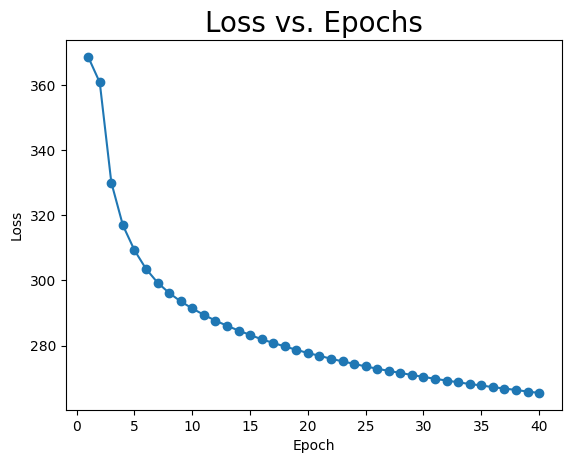

In [10]:
history = model.history["elbo_train"]
plt.plot(range(1, len(history) + 1), history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.show()

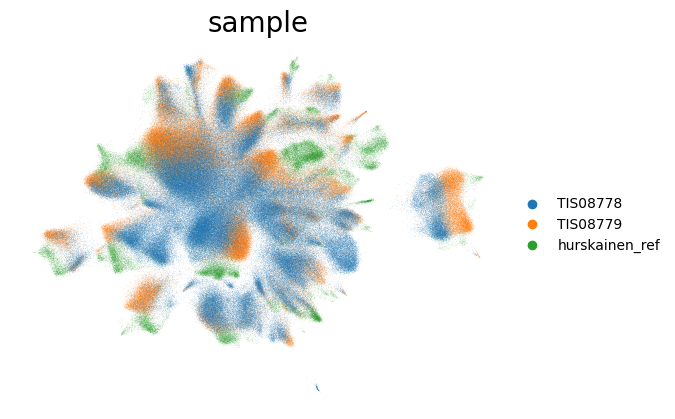

In [11]:
sc.pl.embedding(adata_concat, basis='X_umap_scvi_refalign', color='sample', frameon=False)

### scanvi model 

In [45]:
adata_concat.shape

(655380, 480)

In [46]:
# before running scanvi, filter the reference to include only cells >1000 counts
ref_remove_mask = (adata_concat.obs["sample"] == "hurskainen_ref") & (adata_concat.obs["nCount_RNA"] < 1000)
sum(ref_remove_mask)
adata_concat = adata_concat[~ref_remove_mask, :]

In [47]:
adata_concat.shape

(651597, 480)

In [49]:
# set scanvi celltype key for label prediction
SCANVI_CELLTYPE_KEY = "celltype_scanvi"

adata_concat.obs[SCANVI_CELLTYPE_KEY] = "Unknown"
ref_mask = adata_concat.obs["sample"] == "hurskainen_ref"
adata_concat.obs[SCANVI_CELLTYPE_KEY][ref_mask] = adata_concat.obs['CellType_consolidated'].values

/tmp/ipykernel_1977/3101180123.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_concat.obs[SCANVI_CELLTYPE_KEY] = "Unknown"
/tmp/ipykernel_1977/3101180123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_concat.obs[SCANVI_CELLTYPE_KEY][ref_mask] = adata_concat.obs['CellType_consolidated'].values


In [51]:
# train scanvi model 
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata_concat,
    unlabeled_category="Unknown",
    labels_key=SCANVI_CELLTYPE_KEY,
)

print('training scanvi')
scanvi_model.train(accelerator="gpu",
                   max_epochs = 40
                  )  

# save
scanvi_model.save(os.path.join(out_dir, 'models') , prefix='scanvi_mouselung_intergrate_hurskainen_ref', overwrite=True)

# predict
print('prediction')
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTION_KEY = "C_scANVI"

adata_concat.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata_concat)
adata_concat.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(adata_concat)

print('nb')
# neighbors
sc.pp.neighbors(adata_concat, use_rep="X_scANVI", key_added='neighbors_scanvi')
print('umap')
sc.tl.umap(adata_concat, neighbors_key='neighbors_scanvi')


# save umap dims to csv
umap_df = pd.DataFrame(adata_concat.obsm['X_umap'], index=adata_concat.obs_names, columns=['umap1', 'umap2'])
filename = os.path.join(out_dir, 'adata_scanvi_refalign_umap_coords.csv')
umap_df.to_csv(filename)

# save adata
adata_concat.write_h5ad(os.path.join(out_dir, 'adata_concat_scanvi.h5ad'), compression='gzip')

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
training scanvi
INFO     Training for 40 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/workspace/environment/cellcharter-env2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 17/40:  42%|████▎     | 17/40 [31:35<42:30, 110.91s/it, v_num=1, train_loss_step=224, train_loss_epoch=209]

#### scanvi visualization 

In [12]:
# load adata (if not already loaded)
adata_concat = sc.read_h5ad(os.path.join(out_dir, 'adata_concat_scanvi.h5ad'))

In [19]:
# Separate reference and xenium 
adata_concat_ref = adata_concat[adata_concat.obs['sample']=='hurskainen_ref', :]
adata_concat_xen = adata_concat[adata_concat.obs['sample']!='hurskainen_ref', :]

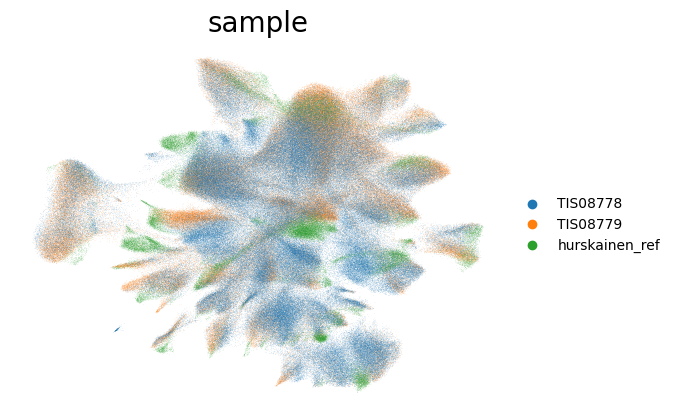

In [24]:
sc.pl.embedding(adata_concat, basis='X_umap', color ='sample', frameon=False)

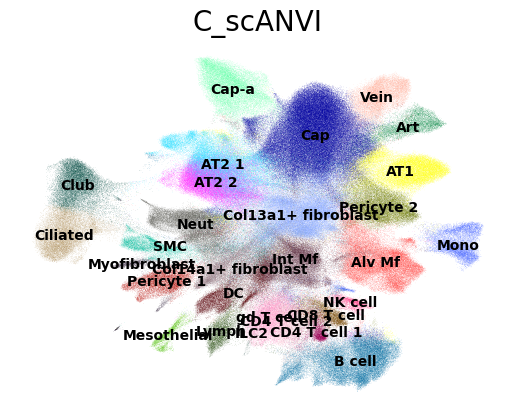

In [17]:
sc.pl.embedding(adata_concat, basis='X_umap', color ='C_scANVI', frameon=False, legend_loc = 'on data')

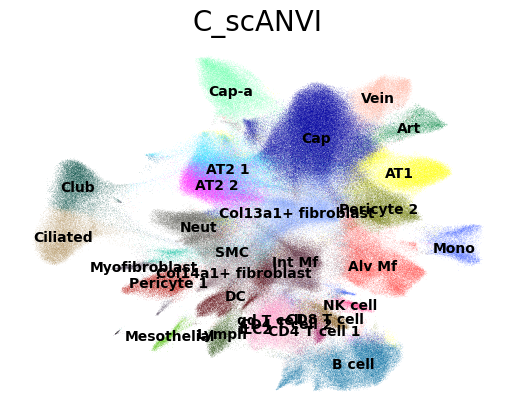

In [25]:
sc.pl.embedding(adata_concat_xen, basis='X_umap', color ='C_scANVI', frameon=False, legend_loc = 'on data')

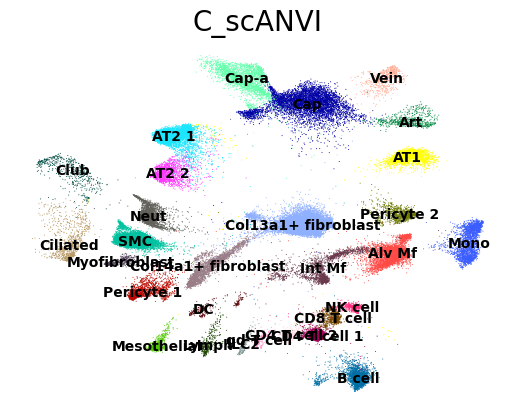

In [20]:
sc.pl.embedding(adata_concat_ref, basis='X_umap', color ='C_scANVI', frameon=False, legend_loc = 'on data')

/home/workspace/environment/cellcharter-env2/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:258: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


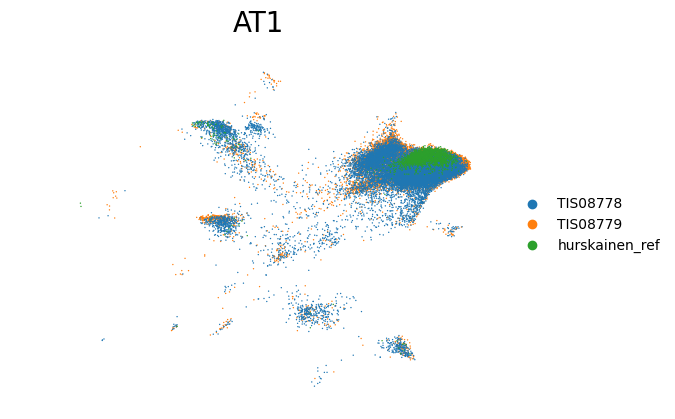

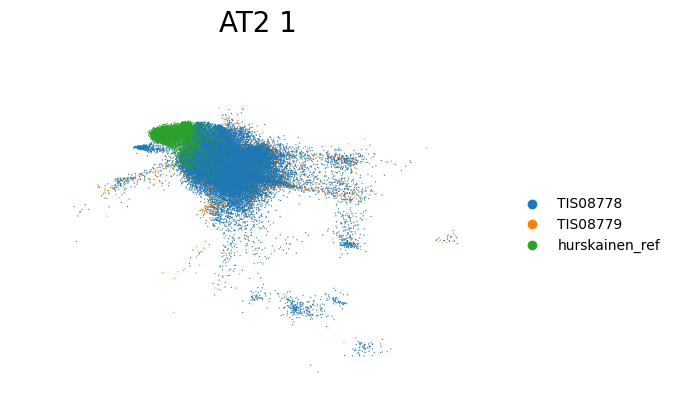

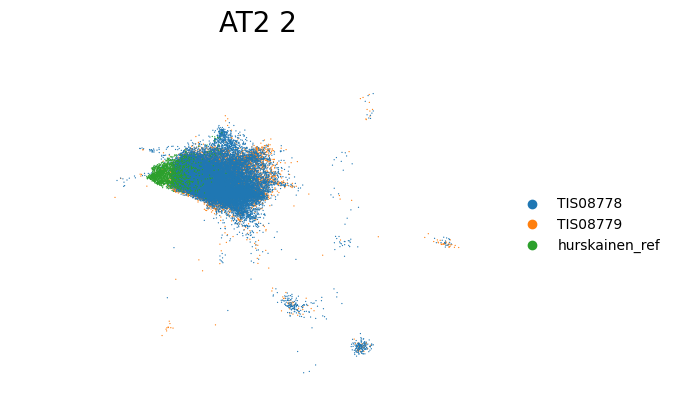

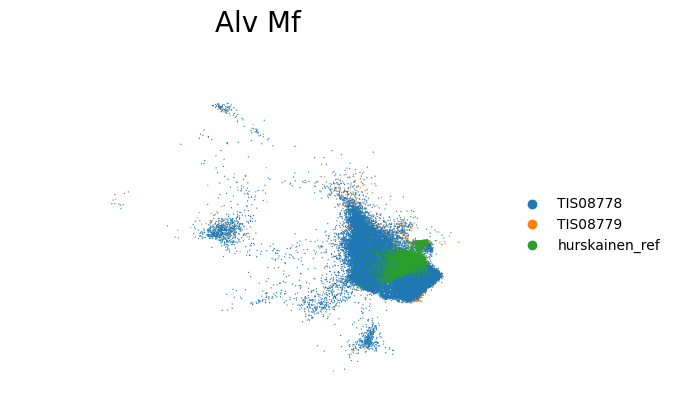

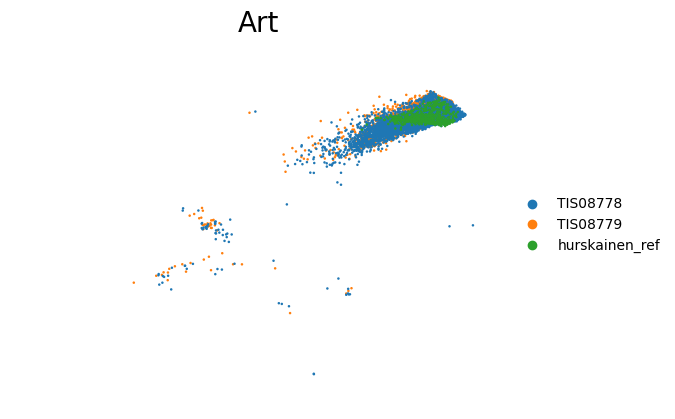

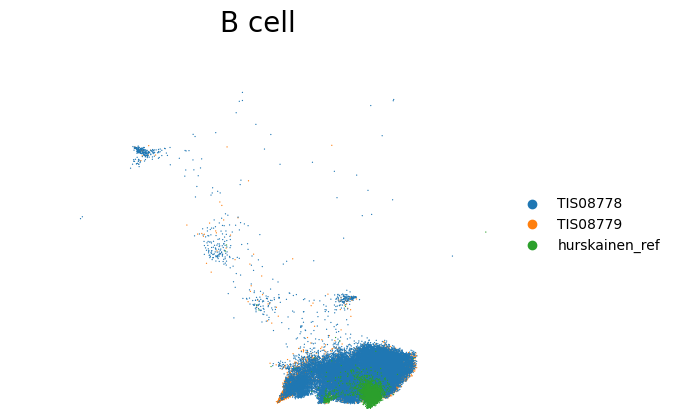

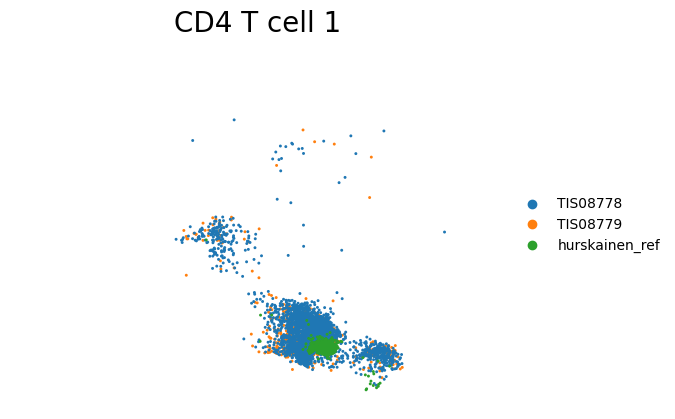

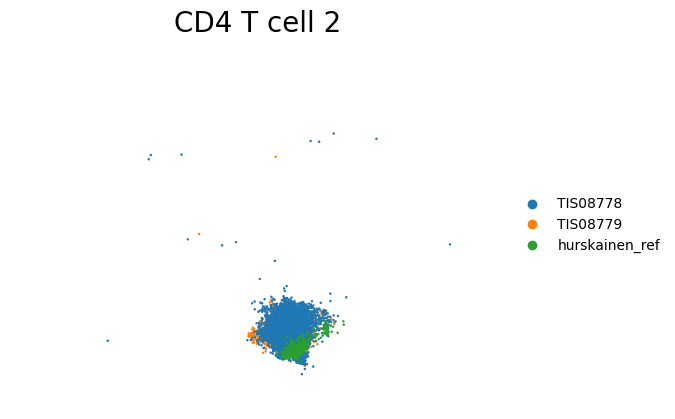

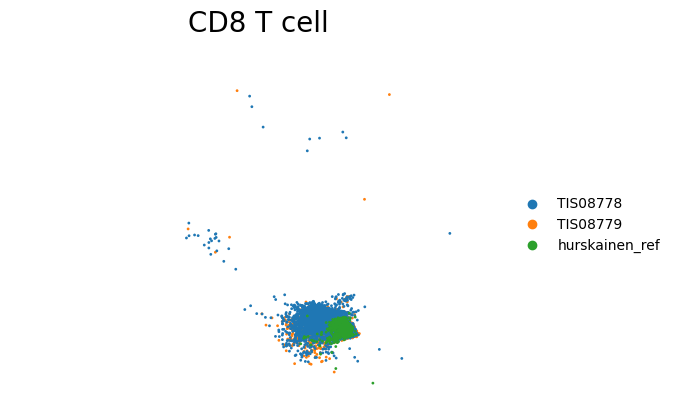

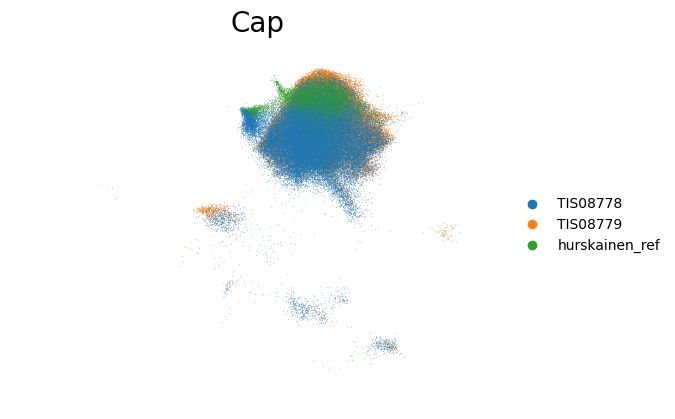

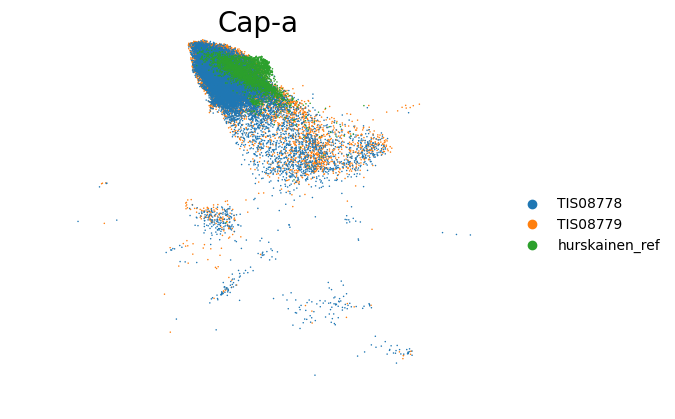

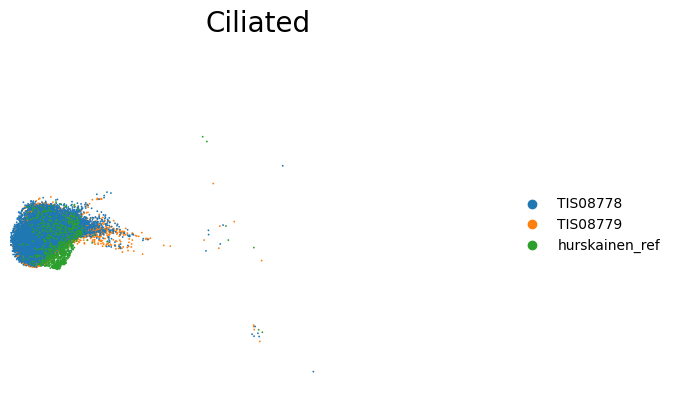

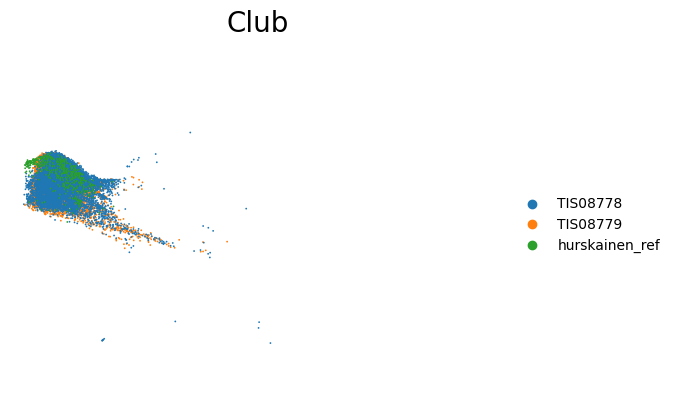

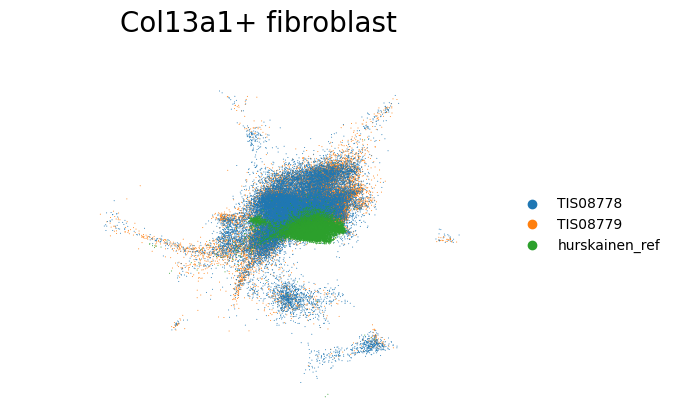

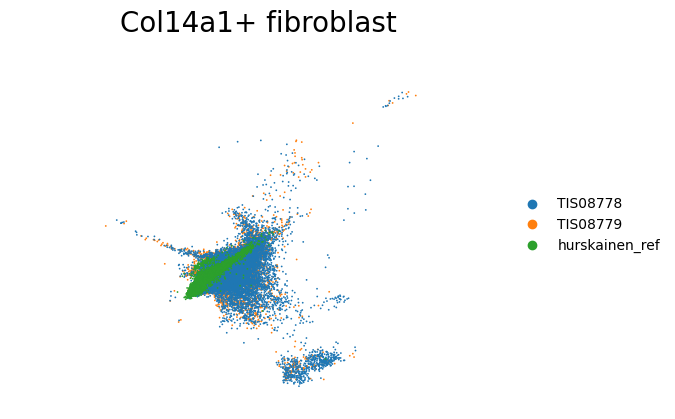

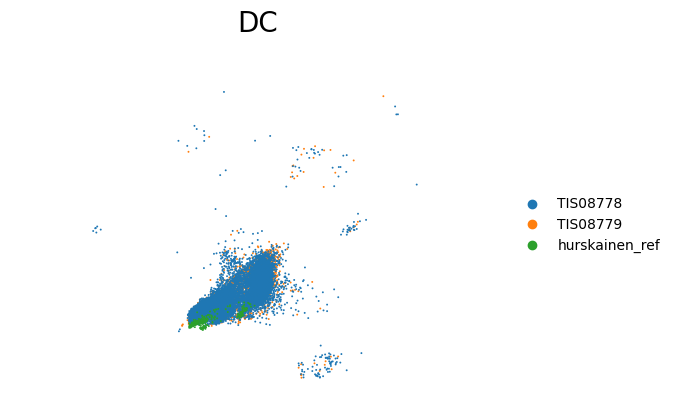

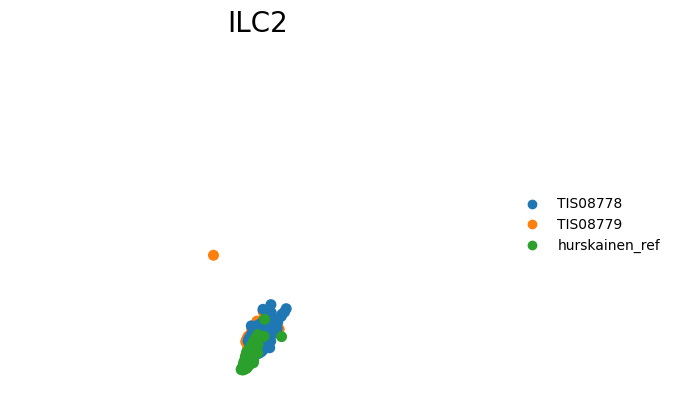

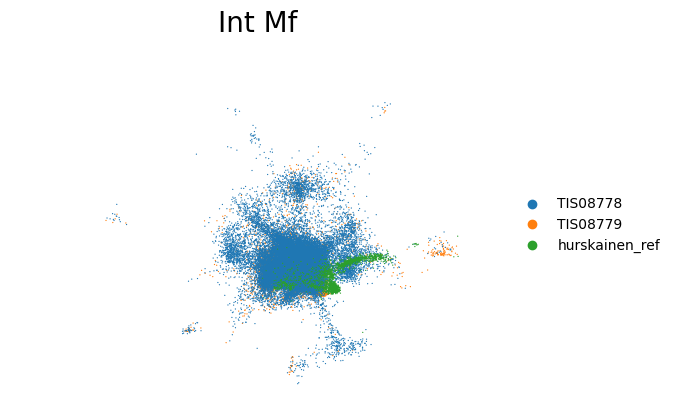

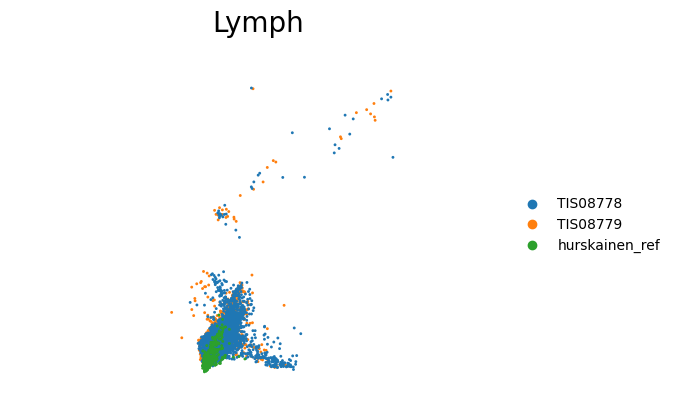

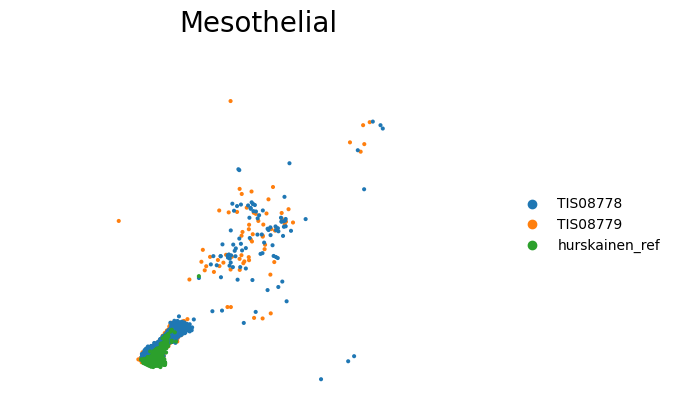

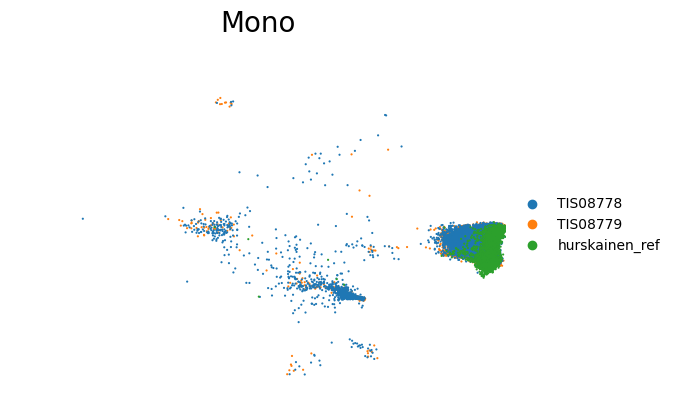

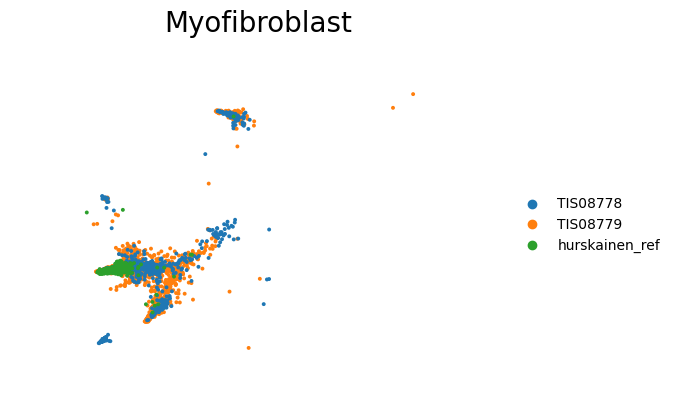

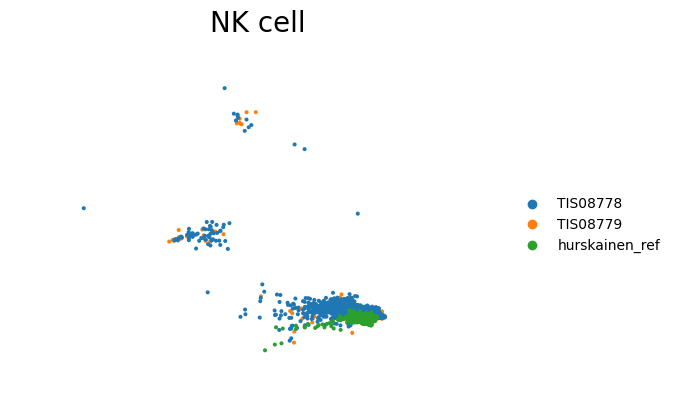

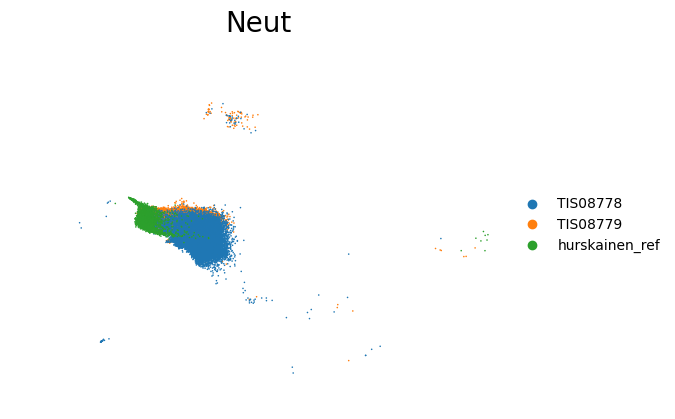

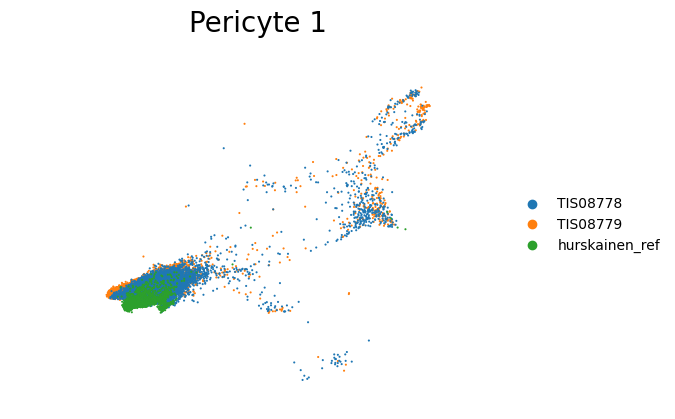

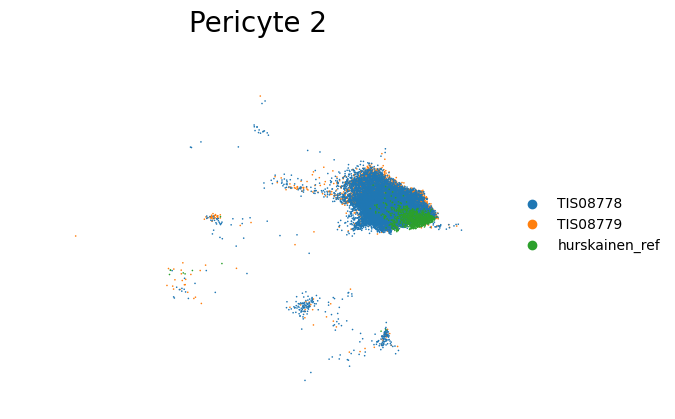

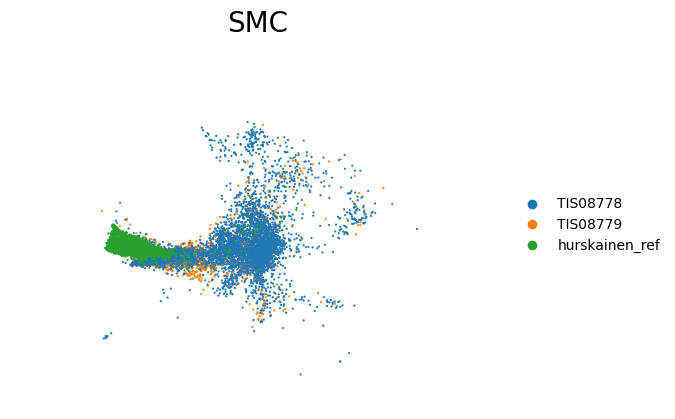

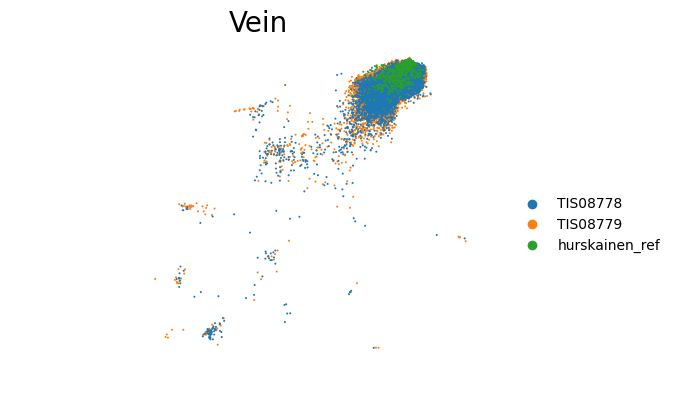

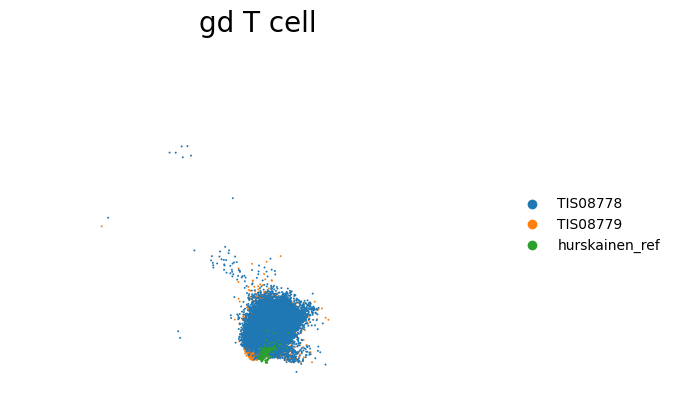

In [21]:
# individual cell labels

scanvi_umap_xlims = [min(adata_concat.obsm['X_umap'][:,0]), max(adata_concat.obsm['X_umap'][:,0])]
scanvi_umap_ylims = [min(adata_concat.obsm['X_umap'][:,1]), max(adata_concat.obsm['X_umap'][:,1])]

for label in adata_concat.obs['C_scANVI'].cat.categories:
    adata_plot = adata_concat[adata_concat.obs['C_scANVI']==label, :]
    sc.pl.embedding(adata_plot, basis='X_umap', color ='sample', frameon=False, show=False, title=label)
    plt.xlim(scanvi_umap_xlims)
    plt.ylim(scanvi_umap_ylims)

## Save scanvi results

In [55]:
# save xenium labels to csv
filename = os.path.join(out_dir, 'adata_xen_scanvi_labels.csv')
adata_concat_xen.obs[['C_scANVI']].to_csv(filename)

In [5]:
import session_info
print('active conda environment: ', os.path.basename(sys.prefix))
session_info.show()

active conda environment:  cellcharter-env2


/home/workspace/environment/cellcharter-env2/lib/python3.12/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)
